# Introduction aux réseaux LSTM (Long Short-Term Memory)

Les réseaux de neurones LSTM (Long Short-Term Memory) sont une catégorie spéciale de réseaux de neurones récurrents (RNN) capables de capturer des dépendances à long terme dans les données séquentielles. Ils sont particulièrement utiles dans les domaines du traitement du langage naturel (NLP), de la prévision de séries temporelles, et bien d'autres applications nécessitant la compréhension de séquences de données.

## Pourquoi utiliser les LSTMs?

Les réseaux LSTM sont conçus pour éviter le problème de disparition du gradient, un problème courant avec les architectures RNN standards. Cela les rend particulièrement efficaces pour apprendre à partir de séquences de données où la compréhension des événements passés est cruciale pour prédire les futurs événements.


Les sources des datasets utilisés dans le Hands-on :


AAPL stocks dataset :
https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/input?select=AAPL_2006-01-01_to_2018-01-01.csv



## Utilisation d'un ensemble de données pour prédire la Volatilité du Marché Boursier

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Après l'importation des librairies nécessaires, on importe le dataset après la définition de quelques fonctions utiles

In [ ]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Apple Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Apple Stock Price')
    plt.title('Apple Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Apple Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [ ]:
dataset = pd.read_csv('/content/AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [ ]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

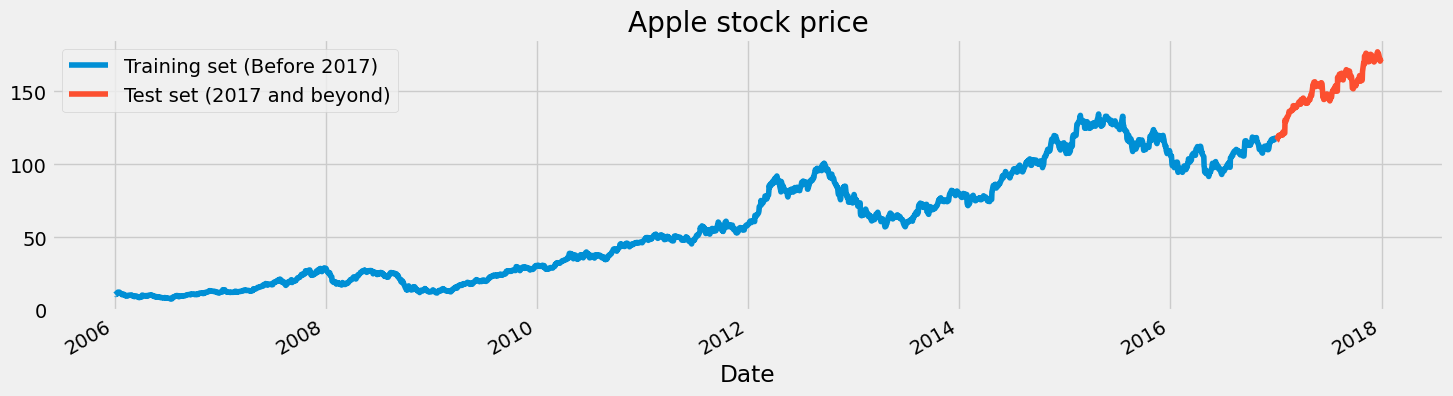

In [ ]:
# Nous avons choisi l'attribut 'High' pour les prix. Voyons à quoi cela ressemble.
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('Apple stock price')
plt.show()

In [ ]:
# Mise à l'échelle de l'ensemble d'entraînement
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# Puisque les LSTMs stockent un état de mémoire à long terme, nous créons une structure de données avec 60 pas de temps et 1 sortie
# Ainsi, pour chaque élément de l'ensemble d'entraînement, nous avons 60 éléments précédents de l'ensemble d'entraînement.
X_train = []
y_train = []
for i in range(60,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Redimensionnement de X_train pour une modélisation efficace
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
# L'architecture LSTM
regressor = Sequential()
# Première couche LSTM avec régularisation Dropout
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Deuxième couche LSTM
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Troisième couche LSTM
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Quatrième couche LSTM
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# La couche de sortie
regressor.add(Dense(units=1))

# Compilation du RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Adaptation à l'ensemble d'entraînement
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 20s 123ms/step - loss: 0.0149
Epoch 2/50
85/85 [==============================] - 14s 170ms/step - loss: 0.0071
Epoch 3/50
85/85 [==============================] - 18s 208ms/step - loss: 0.0060
Epoch 4/50
85/85 [==============================] - 11s 124ms/step - loss: 0.0053
Epoch 5/50
85/85 [==============================] - 11s 131ms/step - loss: 0.0044
Epoch 6/50
85/85 [==============================] - 11s 124ms/step - loss: 0.0038
Epoch 7/50
85/85 [==============================] - 12s 141ms/step - loss: 0.0041
Epoch 8/50
85/85 [==============================] - 10s 121ms/step - loss: 0.0033
Epoch 9/50
85/85 [==============================] - 11s 124ms/step - loss: 0.0031
Epoch 10/50
85/85 [==============================] - 11s 128ms/step - loss: 0.0031
Epoch 11/50
85/85 [==============================] - 11s 127ms/step - loss: 0.0028
Epoch 12/50
85/85 [==============================] - 11s 126ms/step - loss: 0.0029
Epoch 13/50
8

Préparons maintenant l'ensemble de test de manière similaire à l'ensemble d'entraînement. Ce qui a été fait jusqu'à présent est que les 60 premières entrées de l'ensemble de test ont 60 valeurs précédentes, ce qui est impossible à obtenir à moins de prendre l'ensemble des données de l'attribut 'High' pour le traitement.

In [ ]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
# Préparation de X_test et prédiction des prix
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 0s 32ms/step


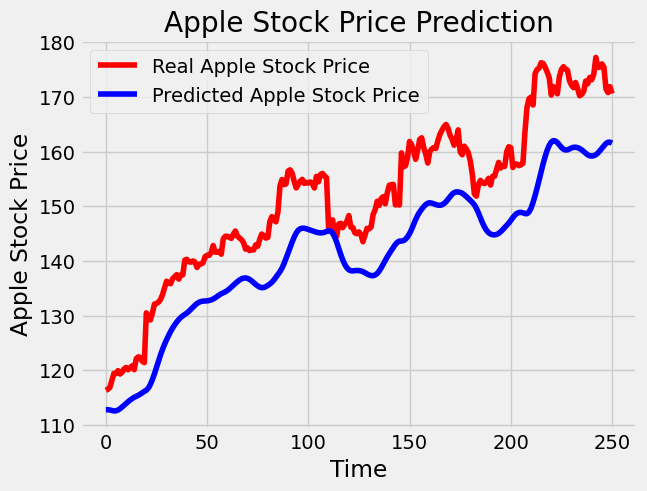

In [ ]:
# Visualisation
plot_predictions(test_set,predicted_stock_price)

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        e = K.tanh(K.dot(inputs, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = inputs * a
        return K.sum(output, axis=1)


In [ ]:
dataset = pd.read_csv('/content/AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
data = dataset['High'].values

# Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Fonction pour créer des sequences
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Creation training et test data
sequence_length = 60
train_size = int(len(data_scaled) * 0.8)
X, y = create_sequences(data_scaled, sequence_length)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Architecture LSTM avec attention
regressor = Sequential()
# Première couche LSTM avec régularisation Dropout
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Deuxième couche LSTM
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Troisième couche LSTM
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Quatrième couche LSTM
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Adding Attention Layer
regressor.add(AttentionLayer())
# La couche de sortie
regressor.add(Dense(units=1))

# Compilation du RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Adaptation à l'ensemble d'entraînement
regressor.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
76/76 [==============================] - 16s 101ms/step - loss: 0.0072
Epoch 2/50
76/76 [==============================] - 9s 115ms/step - loss: 0.0033
Epoch 3/50
76/76 [==============================] - 10s 134ms/step - loss: 0.0025
Epoch 4/50
76/76 [==============================] - 9s 116ms/step - loss: 0.0022
Epoch 5/50
76/76 [==============================] - 9s 121ms/step - loss: 0.0020
Epoch 6/50
76/76 [==============================] - 10s 127ms/step - loss: 0.0018
Epoch 7/50
76/76 [==============================] - 9s 115ms/step - loss: 0.0018
Epoch 8/50
76/76 [==============================] - 8s 107ms/step - loss: 0.0017
Epoch 9/50
76/76 [==============================] - 9s 116ms/step - loss: 0.0016
Epoch 10/50
76/76 [==============================] - 9s 116ms/step - loss: 0.0015
Epoch 11/50
76/76 [==============================] - 8s 101ms/step - loss: 0.0015
Epoch 12/50
76/76 [==============================] - 9s 116ms/step - loss: 0.0014
Epoch 13/50
76/76 [===

17/17 [==============================] - 1s 30ms/step


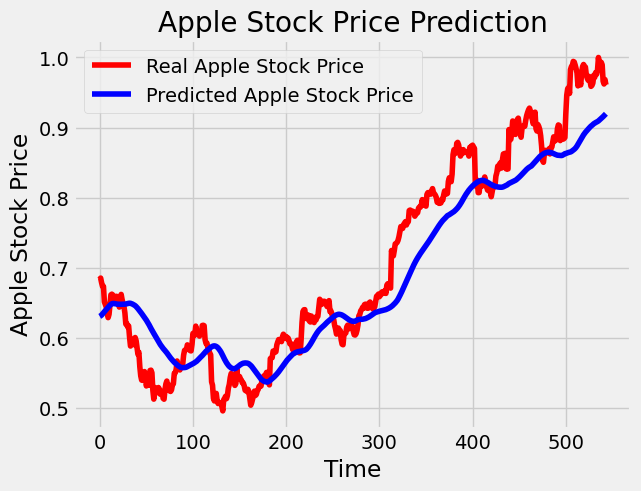

The root mean squared error is 0.050866102728415546.


In [ ]:
# Prediction stock price
predicted_stock_price = regressor.predict(X_test)

# Visualisation
plot_predictions(y_test, predicted_stock_price)
return_rmse(y_test, predicted_stock_price)
